In [2]:
import pandas as pd
import matplotlib.pyplot as plt

1. Look at the BAUS zoning for buildings built in PBA50+ DBP

In [4]:
# new buildings output for PBA50+ DBP
pz = pd.read_csv("M:/urban_modeling/baus/PBA50Plus/Draft Blueprint Datasets/\
PBA50Plus_Draft_Blueprint_v8_znupd_nodevfix_rerun/core_summaries/PBA50Plus_Draft_Blueprint_v8_znupd_nodevfix_rerun_parcel_summary_2010.csv")

2. Add variables to categorize the parcels' "density type" (rural/suburban/urban-suburban/urban) in order to compare againsst their BAUS zoning

In [5]:
# parcels to jurisdiction crosswalk
pg = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/parcels_geography_2024_02_14.csv")
# jurisdiction to "subregion" crosswalk
juris = pd.read_csv("M:/urban_modeling/baus/juris_subregion.csv")

# make the juris column formats match
juris['jurisdiction'] = juris['jurisdiction'].str.lower().str.replace(' ','_').str.replace('.','')
juris.loc[juris.jurisdiction.str.contains("county"), 'jurisdiction'] = 'unincorporated_' + juris['jurisdiction']
juris['jurisdiction'] = juris['jurisdiction'].str.replace("_county", '')

# parcel to TAZ crosswalk
ptaz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/2020_08_17_parcel_to_taz1454sub.csv")
# taz to superdistrict crosswalk
taz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/taz_geography.csv")
# superdistrict to "subregion" crosswalk
sd = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/superdistricts_geography.csv")

In [6]:
# merge the jurisdiction and superdistrict "subregion" variables
pz = pz.merge(pg[['PARCEL_ID', 'juris']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
              .merge(juris, left_on='juris', right_on='jurisdiction', how='left')

pz = pz.merge(ptaz[['PARCEL_ID', 'ZONE_ID']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
              .merge(taz[['zone', 'superdistrict']], left_on='ZONE_ID', right_on='zone', how='left')\
              .merge(sd, left_on='superdistrict', right_on='number')

pz = pz.rename(columns={"subregion_x": "subregion_juris", "subregion_y": "subregion_sd"})

3. Add the base zoning to parcels in order to lookup the corresponding zoning input

In [7]:
# latest parcels zoning file
pz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/zoning/zoning_parcels_2024-04-30.csv")
# latest parcel lookup file
zl = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/zoning/zoning_lookup_2024-04-30.csv")
zl = zl.rename(columns={"name": "zoning_name", "max_dua":"max_dua_zoning", "max_far": "max_far_zoning"})

# merge the zoning lookup to buildings
pz = pz.merge(pz[['PARCEL_ID', 'zoning_id']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
.merge(zl[['id', 'zoning_name', 'max_dua_zoning', 'max_far_zoning']], left_on='zoning_id', right_on='id', how='left')

4. Look at the BAUS zoning for parcels as compared to their categorized "density type" and lookup the zoning input for any outliers

BAUS zoning processing:
- Apply BAUS zoning processing from imputation- this infers DUA for far/height and FAR from height, but still picks the min
- eliminates zoning on nodev parcels
- applies rural zoning outside of the urban footprint
- sets max dua to be the highest built density in a TAZ, or if there are no buildings max dua = 4

3a. Look at DUA by "density type"

Rural superdistricts are ['Tri Valley' 'S Leandro Hayward' 'Northern Sonoma' 'Fremont'
 'S Ramon Danville' 'East Contra Costa' 'Martinez Concord'
 'Napa Remainder' 'SF S SE' 'Redwood City' 'Southern Sonoma'
 'Santa Rosa Area' 'Southern Marin' 'Richmond Pinole' 'Lamorinda WC'
 'Oakland Alameda' 'Napa City and S' 'Central Marin' 'Golden Triangle'
 'Daly City Millbrae' 'Solano Remainder' 'Berkeley Eville' 'San Mateo'
 'San Jose CBD' 'West San Jose' 'Palo Alto' 'Northern Marin'
 'East San Jose' 'South San Jose' 'Vallejo Benicia' 'SE Snta Clara Cnty']
They correspont to ['unincorporated_alameda' 'unincorporated_contra_costa'
 'unincorporated_san_mateo' 'unincorporated_sonoma' 'unincorporated_napa'
 'unincorporated_marin' 'unincorporated_santa_clara'
 'unincorporated_solano']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


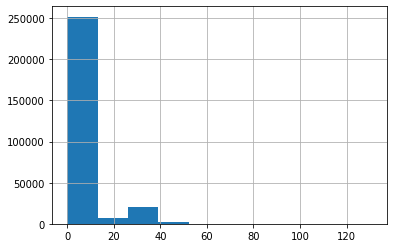

In [8]:
# use jurisdiction-level subregion type since it has greater spatial resolution
rural = pz.loc[pz.subregion_juris == "Unincorporated"]
print("Rural superdistricts are {}".format(rural.name.unique()))
print("They correspont to {}".format(rural.juris.unique()))
print("Their distribution of max DUA is {}".format(rural.max_dua.hist()))

In [9]:
print("Number of rural parcels with DUA > 60 is {}".format(len(rural.loc[rural.max_dua > 60].parcel_id.unique())))
print("This includes {} zoning codes".format(len(rural.loc[rural.max_dua > 60].zoning_name.unique())))
print("Zoning for those parcels is")
rural.loc[rural.max_dua > 60][['zoning_name', 'max_dua','max_dua_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_dua', ascending=False)

Number of rural parcels with DUA > 60 is 402
This includes 68 zoning codes
Zoning for those parcels is


,max_dua,max_dua_zoning
zoning_name,,
M-1_pba40,130.677114,217.800
C-MU (BASIS),113.255005,261.360
C-2/NFO/S-1/DR_pba40,107.448000,107.448
R-1/S-10_pba40,104.544000,104.544
UR8_pba40,101.640000,101.640
...,...,...
LC_pba40,70.914241,101.640
C1 (BASIS),69.535493,0.000
CN (BASIS),69.535493,0.000


Suburban superdistricts are ['Tri Valley' 'Northern Sonoma' 'S Ramon Danville' 'East Contra Costa'
 'Martinez Concord' 'Napa Remainder' 'Southern Sonoma' 'Santa Rosa Area'
 'Richmond Pinole' 'Lamorinda WC' 'Napa City and S' 'Central Marin'
 'Solano Remainder' 'San Mateo' 'Northern Marin' 'Vallejo Benicia'
 'SE Snta Clara Cnty']
The correspond to ['livermore' 'pleasanton' 'dublin' 'san_ramon' 'healdsburg' 'cloverdale'
 'windsor' 'danville' 'walnut_creek' 'brentwood' 'oakley' 'antioch'
 'pittsburg' 'concord' 'clayton' 'martinez' 'lafayette' 'pleasant_hill'
 'calistoga' 'st_helena' 'napa' 'yountville' 'petaluma' 'rohnert_park'
 'sonoma' 'cotati' 'santa_rosa' 'sebastopol' 'orinda' 'moraga'
 'american_canyon' 'novato' 'rio_vista' 'fairfield' 'dixon' 'vacaville'
 'suisun_city' 'half_moon_bay' 'benicia' 'gilroy' 'morgan_hill']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


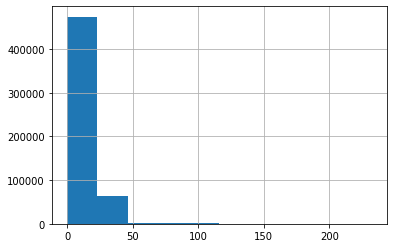

In [10]:
suburban = pz.loc[pz.subregion_juris == 'Inlandcoastaldelta']
print("Suburban superdistricts are {}".format(suburban.name.unique()))
print("The correspond to {}".format(suburban.juris.unique()))
print("Their distribution of max DUA is {}".format(suburban.max_dua.hist()))

In [11]:
print("Number of suburban parcels with DUA > 100 is {}".format(len(suburban.loc[suburban.max_dua > 100].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburban.loc[suburban.max_dua > 100].zoning_name.unique())))
print("Zoning for those parcels is")
suburban.loc[suburban.max_dua > 100][['zoning_name', 'juris', 'max_dua','max_dua_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_dua', ascending=False)

Number of suburban parcels with DUA > 100 is 517
This includes 15 zoning codes
Zoning for those parcels is


,juris,max_dua,max_dua_zoning
zoning_name,,,
Core Mixed Use (BASIS),santa_rosa,232.0000,232.0000
Neighborhood Mixed Use (BASIS),santa_rosa,174.0000,174.0000
SC_pba40,walnut_creek,143.7480,143.7480
Core Mixed Use (CMU) (HE Data),santa_rosa,128.0000,128.0000
DMX (HE Data),concord,125.0000,125.0000
DP (HE Data),concord,125.0000,125.0000
ComGen_pba40,gilroy,120.2256,120.2256
DTHist_pba40,gilroy,108.9000,108.9000
MU-GT_pba40,walnut_creek,108.9000,108.9000


Suburban-urban superdistricts are ['Tri Valley' 'S Leandro Hayward' 'Fremont' 'SF S SE' 'Redwood City'
 'Southern Marin' 'Richmond Pinole' 'Oakland Alameda' 'Napa City and S'
 'Central Marin' 'Golden Triangle' 'Daly City Millbrae' 'Solano Remainder'
 'Berkeley Eville' 'San Mateo' 'San Jose CBD' 'West San Jose' 'Palo Alto'
 'East San Jose' 'Vallejo Benicia']
The correspond to ['fremont' 'hayward' 'san_leandro' 'union_city' 'newark' 'milpitas'
 'daly_city' 'brisbane' 'redwood_city' 'woodside' 'menlo_park'
 'san_carlos' 'east_palo_alto' 'atherton' 'portola_valley' 'belmont'
 'palo_alto' 'larkspur' 'mill_valley' 'sausalito' 'tiburon' 'corte_madera'
 'belvedere' 'san_rafael' 'ross' 'richmond' 'hercules' 'san_pablo'
 'pinole' 'el_cerrito' 'albany' 'berkeley' 'alameda' 'piedmont'
 'emeryville' 'vallejo' 'fairfax' 'san_anselmo' 'sunnyvale' 'santa_clara'
 'mountain_view' 'cupertino' 'millbrae' 'south_san_francisco' 'san_bruno'
 'pacifica' 'burlingame' 'colma' 'hillsborough' 'san_mateo' 'foster_

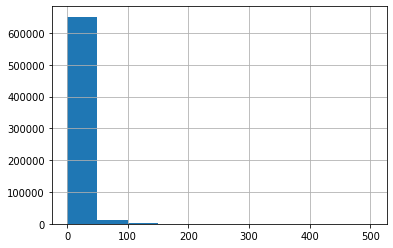

In [12]:
suburbanurban = pz.loc[pz.subregion_juris == 'Bayside']
print("Suburban-urban superdistricts are {}".format(suburbanurban.name.unique()))
print("The correspond to {}".format(suburbanurban.juris.unique()))
print("Their distribution of max DUA is {}".format(suburbanurban.max_dua.hist()))

In [13]:
print("Number of Suburban-urban parcels with DUA > 100 is {}".format(len(suburbanurban.loc[suburbanurban.max_dua > 100].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburbanurban.loc[suburbanurban.max_dua > 100].zoning_name.unique())))
print("Zoning for those parcels is")
suburbanurban.loc[suburbanurban.max_dua > 100][['zoning_name', 'juris', 'max_dua','max_dua_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_dua', ascending=False)

Number of Suburban-urban parcels with DUA > 100 is 1381
This includes 92 zoning codes
Zoning for those parcels is


,juris,max_dua,max_dua_zoning
zoning_name,,,
Mixed Use with Residential (MUR) (HE Data),emeryville,502.00000,502.00
C-DMU Core (HE Data),berkeley,406.19265,418.30
C-DMU Outer Core (HE Data),berkeley,345.70000,345.70
C-DMU Corridor (HE Data),berkeley,274.80000,274.80
MXD3 (HE Data),milpitas,250.00000,250.00
...,...,...,...
R1B6 (BASIS),palo_alto,101.64000,101.64
RA1 (BASIS),los_altos_hills,101.64000,101.64
RHS (BASIS),los_altos_hills,101.64000,101.64


Urban superdistricts are ['S Leandro Hayward' 'SF S SE' 'Lamorinda WC' 'Oakland Alameda' 'SF NW'
 'Golden Triangle' 'Daly City Millbrae' 'Berkeley Eville' 'SF SW'
 'San Jose CBD' 'West San Jose' 'East San Jose' 'SF NE' 'South San Jose'
 'SE Snta Clara Cnty']
The correspond to ['oakland' 'san_francisco' 'san_jose']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


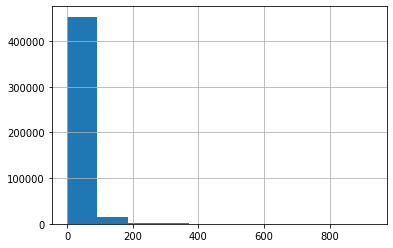

In [14]:
urban = pz.loc[pz.subregion_juris == 'Big Three']
print("Urban superdistricts are {}".format(urban.name.unique()))
print("The correspond to {}".format(urban.juris.unique()))
print("Their distribution of max DUA is {}".format(urban.max_dua.hist()))

In [15]:
print("Number of Urban parcels with DUA > 200 is {}".format(len(urban.loc[urban.max_dua > 200].parcel_id.unique())))
print("This includes {} zoning codes".format(len(urban.loc[urban.max_dua > 250].zoning_name.unique())))
print("Zoning for those parcels is")
urban.loc[urban.max_dua > 200][['zoning_name', 'juris', 'max_dua','max_dua_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_dua', ascending=False)

Number of Urban parcels with DUA > 200 is 3295
This includes 50 zoning codes
Zoning for those parcels is


,juris,max_dua,max_dua_zoning
zoning_name,,,
TB DTR (HE Data),san_francisco,927.653103,1559.7
RH DTR (HE Data),san_francisco,927.653103,1559.7
C-3-G (HE Data),san_francisco,895.200000,895.2
DOWNTOWN- OFFICE-300-S_pba40,san_francisco,871.200000,871.2
C-3-O (HE Data),san_francisco,810.300000,270.1
...,...,...,...
NCT-UPPER MARKET (HE Data),san_francisco,202.600000,202.6
RED (HE Data),san_francisco,202.600000,202.6
RCD (HE Data),san_francisco,202.600000,202.6


3b. Look at FAR by "density type"

Rural distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


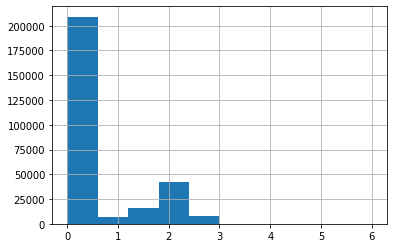

In [16]:
print("Rural distribution of max FAR is {}".format(rural.max_far.hist()))

In [17]:
print("Number of rural parcels with FAR > 3 is {}".format(len(rural.loc[rural.max_far > 3].parcel_id.unique())))
print("This includes {} zoning codes".format(len(rural.loc[rural.max_far > 3].zoning_name.unique())))
print("Zoning for those parcels is")
rural.loc[rural.max_far > 3][['zoning_name', 'juris', 'max_far','max_far_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_far', ascending=False)


Number of rural parcels with FAR > 3 is 310
This includes 47 zoning codes
Zoning for those parcels is


,juris,max_far,max_far_zoning
zoning_name,,,
C-MU (BASIS),unincorporated_san_mateo,6.000000,6.000000
UV (BASIS),unincorporated_santa_clara,5.346793,10.000000
115 - General Commercial_pba40,unincorporated_alameda,5.000000,2.000000
PC/DR (BASIS),unincorporated_san_mateo,5.000000,NaN
M-3 (BASIS),unincorporated_contra_costa,5.000000,0.000000
115 - Medical Dental_pba40,unincorporated_alameda,5.000000,2.000000
MH_pba40,unincorporated_contra_costa,5.000000,NaN
MS (BASIS),unincorporated_contra_costa,5.000000,NaN
NODEV_pba40,unincorporated_san_mateo,5.000000,NaN


Suburban distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


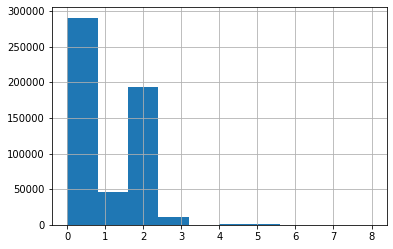

In [18]:
print("Suburban distribution of max FAR is {}".format(suburban.max_far.hist()))

In [19]:
print("Number of suburban parcels with FAR > 4 is {}".format(len(suburban.loc[suburban.max_far > 4].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburban.loc[suburban.max_far > 4].zoning_name.unique())))
print("Zoning for those parcels is")
suburban.loc[suburban.max_far > 4][['zoning_name', 'juris', 'max_far','max_far_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_far', ascending=False)

Number of suburban parcels with FAR > 4 is 1953
This includes 119 zoning codes
Zoning for those parcels is


,juris,max_far,max_far_zoning
zoning_name,,,
Core Mixed Use (BASIS),santa_rosa,8.000000,8.000000
Station Mixed Use (BASIS),santa_rosa,6.000000,6.000000
Neighborhood Mixed Use (BASIS),santa_rosa,6.000000,6.000000
DTMU_pba40,concord,6.000000,6.000000
DMX (HE Data),concord,6.000000,6.000000
...,...,...,...
CMX (HE Data),concord,4.581997,1.000000
SC_pba40,walnut_creek,4.417900,3.300000
C-C (BASIS),walnut_creek,4.417900,0.000000


Suburban-urban distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


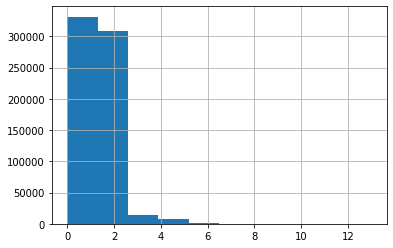

In [20]:
print("Suburban-urban distribution of max FAR is {}".format(suburbanurban.max_far.hist()))

In [21]:
print("Number of suburban-urban parcels with FAR > 6 is {}".format(len(suburbanurban.loc[suburbanurban.max_far > 6].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburbanurban.loc[suburbanurban.max_far > 6].zoning_name.unique())))
print("Zoning for those parcels is")
suburbanurban.loc[suburbanurban.max_far > 6][['zoning_name', 'juris', 'max_far','max_far_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_far', ascending=False)

Number of suburban-urban parcels with FAR > 6 is 483
This includes 44 zoning codes
Zoning for those parcels is


,juris,max_far,max_far_zoning
zoning_name,,,
Moffett Park_pba40,sunnyvale,13.006303,NaN
DIA (BASIS),millbrae,10.000000,2.666667
MSASP General Com Residential MU-30_pba40,millbrae,10.000000,0.500000
R-MLD (BASIS),daly_city,10.000000,NaN
R-MD (BASIS),daly_city,10.000000,NaN
R-3 (BASIS),millbrae,10.000000,2.666667
PD (BASIS),millbrae,10.000000,NaN
NBMU (BASIS),burlingame,10.000000,2.000000
Medium Density Residential_pba40,millbrae,10.000000,2.000000


Urban distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


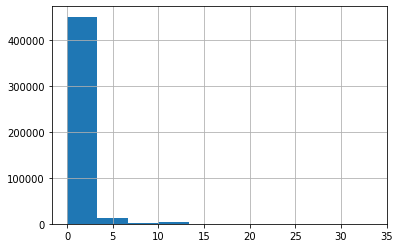

In [22]:
print("Urban distribution of max FAR is {}".format(urban.max_far.hist()))

In [23]:
print("Number of Urban parcels with FAR > 10 is {}".format(len(urban.loc[urban.max_far > 10].parcel_id.unique())))
print("This includes {} zoning codes".format(len(urban.loc[urban.max_far > 10].zoning_name.unique())))
print("Zoning for those parcels is")
urban.loc[urban.max_far > 10][['zoning_name', 'juris', 'max_far','max_far_zoning']].\
groupby(["zoning_name"]).max().sort_values(by='max_far', ascending=False)

Number of Urban parcels with FAR > 10 is 801
This includes 13 zoning codes
Zoning for those parcels is


,juris,max_far,max_far_zoning
zoning_name,,,
DOWNTOWN- OFFICE-500-S_pba40,san_francisco,33.333333,33.333333
DOWNTOWN- GENERAL-120/320-R-2_pba40,san_francisco,21.333333,21.333333
PUBLIC-320-I_pba40,san_francisco,21.333333,21.333333
Downtown_pba40,san_jose,20.333333,30.000000
Central Business District_pba40,oakland,20.000000,20.000000
DOWNTOWN- OFFICE-300-S_pba40,san_francisco,20.000000,20.000000
D-LM-4 (BASIS),oakland,18.333333,18.333333
240' Height Allowed (HE Data),san_francisco,16.000000,NaN
DOWNTOWN- OFFICE (SPECIAL DEVELOPMENT)-200-S_pba40,san_francisco,13.333333,13.333333
